## 1. Libraries and Initial Configuration



In [ ]:
from transformers import AutoTokenizer
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import re

In [20]:
from utils import strip_tags_and_emails

In [10]:
def string_to_list(string):
    """
    Splits a string into a list of words.
    Args:
        string (str): The input string.
    Returns:
        list: A list of words.
    """
    words_list = string.split()
    return words_list


# 2. Data cleaning

## 2.1 Load Data

In [12]:
df = pd.read_excel('datos_sinco.xlsx')
df = df.dropna().reset_index(drop=True)
df['messages'] = df['messages'].astype(str).apply(strip_tags_and_emails)
print(f"Dataframe shape after cleaning: {df.shape}")

Dataframe shape after cleaning: (33091, 3)


## 2.2 Token Length Analysis
We analyze the length of the messages in terms of tokens, both with a simple split and using the BERT tokenizer.
This analysis is crucial for selecting the appropriate input sequence length for the BERT model.
**Why is this important?**
-   The input sequence length determines the maximum number of tokens that can be fed into the BERT model for each message.
-   A large input sequence length can make the model slower and unnecessarily pad short messages, wasting computational resources.
-   A small input sequence length can truncate long messages, leading to loss of valuable information.

**Why use BERT tokenizer tokens instead of word count?**
-   The number of tokens generated by the BERT tokenizer is a more accurate reflection of the actual input size for the model.
-   The BERT tokenizer may split words into subwords, especially for words it doesn't recognize, resulting in a different token count compared to a simple word split.
-   Using the BERT tokenizer's token count ensures that we are setting the input sequence length based on the model's actual input representation.


In [14]:
model_name_bert = 'dccuchile/bert-base-spanish-wwm-uncased'
tokenizer_bert = AutoTokenizer.from_pretrained(model_name_bert)
sample_txt = 'esto ES un ejemplo.'
tokens = tokenizer_bert.tokenize(sample_txt)
tokens

['esto', 'es', 'un', 'ejemplo', '.']

Tokenizing the messages using the BERT tokenizer and counting the number of tokens.

In [15]:
df['token_bert'] = df['messages'].apply(tokenizer_bert.tokenize)
df['n_words_bert'] = df['token_bert'].apply(len)
df['tokens_real'] = df['messages'].apply(string_to_list)
df['n_word_real'] = df['tokens_real'].apply(len)


Token indices sequence length is longer than the specified maximum sequence length for this model (593 > 512). Running this sequence through the model will result in indexing errors


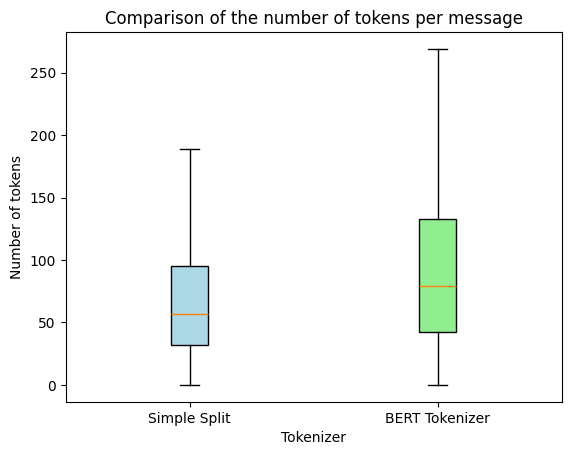

In [17]:
boxplot = plt.boxplot([df['n_word_real'], 
                       df['n_words_bert']],
                       showfliers=False,patch_artist=True)
boxplot['boxes'][0].set(facecolor='lightblue') 
boxplot['boxes'][1].set(facecolor='lightgreen') 
plt.xlabel('Tokenizer')
plt.ylabel('Number of tokens')
plt.title('Comparison of the number of tokens per message')
plt.xticks([1, 2], ['Simple Split','BERT Tokenizer'])
plt.show()

In [18]:
q3_bert = np.percentile(df['n_words_bert'], 75)
q3_real = np.percentile(df['n_word_real'], 75)
print(f"75th percentile (BERT tokenizer): {q3_bert}")
print(f"75th percentile (simple split): {q3_real}")

75th percentile (BERT tokenizer): 133.0
75th percentile (simple split): 95.0


Therefore, the length hyperparameter (number of input tokens) that will be used later will be 133  

## 2.3 Category Analysis
In this section, we analyze the frequency and distribution of message categories and merge similar categories to clean the label space.

In [24]:
print("Number of different categories:", df['category'].nunique())

Number of different categories: 162


In [26]:
category_stats = df.groupby('category').size().reset_index(name='frequency').sort_values(by='frequency', ascending=False)
print(category_stats.head(6).reset_index(drop=True))

                                            category  frequency
0              SOLICITUD DE ACTIVACION USUARIO SINCO       6828
1         CAMBIO DE VOCERIA RESPONSABLE DEL PROYECTO       1889
2                 PROCESO DE VALORACION DEL PROYECTO       1849
3  COMO CANCELAR UN PROYECTO REGISTRADO (EN EVALU...       1578
4                   PASOS PARA REGISTRAR UN PROYECTO       1360
5  Organizaciones / PROBLEMAS CON EL RIF O CÓDIGO...       1115


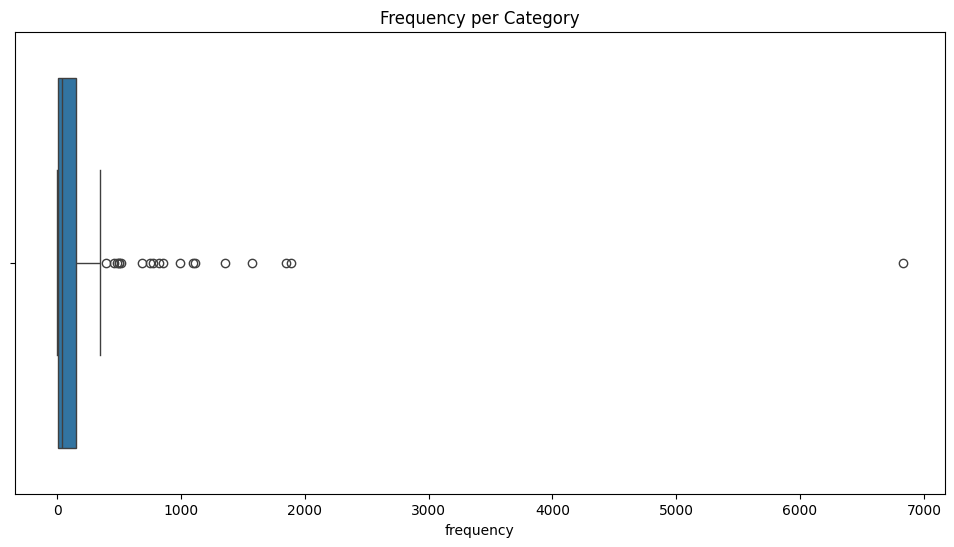

In [27]:
plt.figure(figsize=(12, 6))
sns.boxplot(x='frequency', data=category_stats)
plt.title('Frequency per Category')
plt.show()

> **The distribution of categories is highly right-skewed with many outliers (rare categories).**

## 2.4 Merging classes
There are over 160 categories due to the coexistence of two SINCO labeling systems over time. Some categories represent the same class but have different (or mistyped) names. We create a mapping to unify similar categories and remove irrelevant ones.
By merging and filtering, we reduce noise and improve label consistency, which is critical for machine learning performance.

In [40]:
from categories import category_mapping

df['category'] = df['category'].replace(category_mapping)
# Remove unwanted categories
df = df[~df['category'].isin(['Solicitud de activación usuario sinco', '', 'Otros', 'otros'])]
print("Number of categories after merging and filtering:", df['category'].nunique())

Number of categories after merging and filtering: 90


In [31]:
category_stats = df.groupby('category').size().reset_index(name='frequency').sort_values(by='frequency', ascending=False)

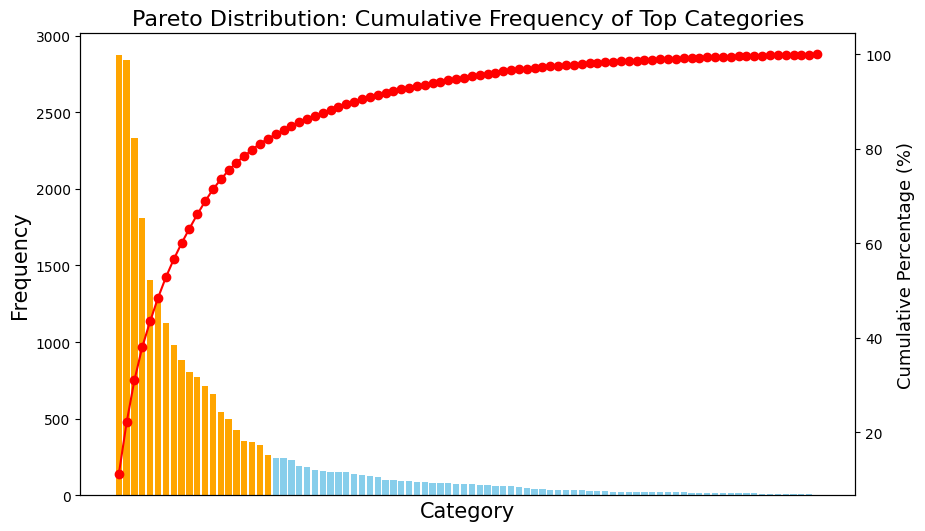

In [41]:
category_stats['cumulative_freq'] = category_stats['frequency'].cumsum()
category_stats['cumulative_pct'] = category_stats['cumulative_freq'] / category_stats['frequency'].sum() * 100
plt.figure(figsize=(10, 6))
plt.bar(category_stats['category'], category_stats['frequency'], color='skyblue')
plt.bar(category_stats['category'][:20], category_stats['frequency'][:20], color='orange')  # Highlight Pareto classes
plt.title('Pareto Distribution: Cumulative Frequency of Top Categories', fontsize=16)
plt.xlabel('Category', fontsize=15)
plt.ylabel('Frequency', fontsize=15)
plt.twinx()
plt.plot(category_stats['category'], category_stats['cumulative_pct'], color='red', marker='o')
plt.ylabel('Cumulative Percentage (%)', fontsize=13)
plt.xticks([])
plt.show()

The highlighted orange bars represent the top 20% of categories covering ~80% of the total messages. This selection ensures that subsequent modeling will focus on the most informative and statistically significant categories.

# 3. Creating the Final Dataset el dataset
In this section, we select the top 15 categories, create the filtered dataset, and export it for modeling.

In [42]:
top_categories = category_stats['category'].iloc[0:15].tolist()

In [44]:
total_mensajes = df.shape[0]

In [ ]:
df = df.reset_index(drop = True)

In [ ]:
data = df[df['category'].isin(categorias)].reset_index(drop=True)

In [ ]:
mensajes_20 = data.shape[0]

In [ ]:
mensajes_20*100/total_mensajes

81.6166828814348

In [ ]:
data2 = data.iloc[:,1:3]
data2

,category,messages
0,Rendición de cuentas,"Reciban un saludo bolivariano, chavista y anti..."
1,Problemas con cuentas bancarias,"Saludos cordiales, les escribe la vocera Shirl..."
2,Rendición de cuentas,"SALUDOS, EL PRESENTE COMUNICADO EN CON LA FINA..."
3,Proceso de valorción del proyecto,"BUENAS NOCHES SEÑORES SINCO, RECIBAN UN CORDIA..."
4,Rendición de cuentas,buenas noches le solicito me oriente so...
...,...,...
19290,Respuesta a comunicación emitida,Actualmente la organización no posee ninguna p...
19291,Respuesta a comunicación emitida,Con este reporte llegamos a un 100% del total...
19292,Problemas con el RIF o código Situr,ANTE TODO RECIBA UN RESPETUOSO SALUDO DE PARTE...
19293,Cambio de vocería,"Buenas tarde, reciban un cordial saludo en ben..."


In [ ]:
agrupado_por_frecuencia = data2.groupby('category').size().reset_index(name='frecuencia').sort_values(by='frecuencia',ascending=False)

In [ ]:
agrupado_por_frecuencia

,category,frecuencia
6,Cambio de vocería,2687
15,Proceso de valorción del proyecto,2611
7,Cancelación de proyecto,2302
17,Rendición de cuentas,1797
12,Pasos para registrar un proyecto,1392
5,Cambio de correo electrónico,1126
8,Dificultad en el modulo de registrar,843
18,Respuesta a comunicación emitida,722
10,Electricidad,680
9,Ejecución de Proyecto / REPORTE DE INSUMOS,676


In [ ]:
#creamos vector de categorías (1 si pertenece a esa categoría y 0 si no)
for categoria in categorias:
  df[categoria] =df['category'].apply(lambda x: 1 if x == categoria else 0)

In [ ]:
data2.to_excel('datos_tesis_filtrado.xlsx',index=False)